# Always run these first three cells.

In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# IMPORT PACKAGES

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as feature
import cmocean.cm
import pandas as pd
import xarray as xr
import collections
from scipy.stats import ttest_ind, ttest_rel
# fix to cartopy issue right now
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [3]:
# CODE TO CALCULATE SEASONAL AVERAGE

# Taken from: https://xarray.pydata.org/en/v0.14.0/examples/monthly-means.html
# However test plot in "Seasonal Mean Example" produces somewhat different results-- not sure why.
# usage example: ds_weighted = season_mean(ds,calendar='noleap')

dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
       'julian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

def season_mean(ds, calendar='standard'):

    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                coords=[ds.time], name='month_length')
    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')

def annual_season_mean(ds, calendar='standard'): # Added 7-9-20
    # TRUNCATE TIME SERIES IN ADVANCE SO THERE ARE ONLY COMPLETE YEARS, OTHERWISE GET INF/0 AT END FOR SOME SEASONS
    ml = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                coords=[ds.time], name='month_length') # ml stands for month_length
    ml_seas = {}
    ml_seas_sums = {}
    weights = {}
    ds_seas = {}
    ann_seas_mean_v1 = {}
    for seas in ['DJF','MAM','JJA','SON']:
        ml_seas[seas] = ml.where(ds['time.season'] == seas)
        ml_seas_sums[seas] = ml_seas[seas].rolling(min_periods=3, center=True, time=3).sum()
        if seas == 'DJF':
            ml_seas[seas] = ml_seas[seas].shift(time=1) # done to ensure weights for consecutive D-J-F add up to 1 despite crossing year
        weights[seas] = ml_seas[seas].groupby('time.year') / ml_seas_sums[seas].groupby('time.year').sum()
        
        ds_seas[seas] = ds.where(ds['time.season'] == seas)
        if seas == 'DJF':
            ds_seas[seas] = ds_seas[seas].shift(time=1)
        ann_seas_mean_v1[seas] = (ds_seas[seas] * weights[seas]).groupby('time.year').sum(dim='time') # 0 AT END IF NOT COMPLETE YEAR
    ann_seas_mean_v1['DJF'] = ann_seas_mean_v1['DJF'].isel(year=slice(1,len(ann_seas_mean_v1['DJF'].year)))
    return ann_seas_mean_v1


# Can skip these cells if ran already.

In [3]:
# PATHS TO DATA FILES

direc = '/tigress/GEOCLIM/janewb/MODEL_OUT'
files = {}
files['ctrl'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/precip.00010101-03000101.atmos_month.nc'
files['cam'] = '/tigress/janewb/MODEL_OUT_HERE/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/precip.00010101-02050101.atmos_month.nc'
files['hitopo'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/precip.00010101-06000101.atmos_month.nc'
files['cesm_ctrl'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/b40.1850.track1.1deg.006.cam2.h0.PRECT.120001-130012.nc'
files['cesm_cam']  = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/ccsm4pi_topo2.cam2.h0.PRECT.000101-029912.nc'
files['gpcp'] = '/tigress/wenchang/data/gpcp/v2p3/precip.mon.mean.197901_201808.nc'
files['cmap'] = '/tigress/janewb/OBS/CMAP/precip.mon.mean.nc'
files['imerg'] = '/tigress/janewb/OBS/GPM/precip.mon.mean.nc'

land_files = {}
land_files['ctrl'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/land_mask.nc'
land_files['imerg'] = '/tigress/janewb/OBS/GPM/IMERG_land_sea_mask.nc'
land_files['cesm_ctrl'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_topo_mods/hose1Sv_ccsm4_pi01.cam2.h0.0001-01.nc'
land_files['cesm_cam'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_topo_mods/shf_heating_topo6.cam2.h0.0001-01.nc'

In [16]:
xr.open_dataset(files['cesm_ctrl'])

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 1212)
Coordinates:
  * time     (time) object 1200-02-01 00:00:00 ... 1301-01-01 00:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    PRECT    (time, lat, lon) float32 ...
Attributes:
    creation_date:  Mon May 18 23:19:29 EDT 2020
    Conventions:    None
    source_file:    writecdf_PRECT_ccsm4picont.120001-130012.ncl
    title:          netCDF file containing monthly climatology

In [57]:
# DATA CLEANING

dat = {}
pr = {}
tsel = {}

x = 'lon'
y = 'lat'
precip_var = 'precip'
units = 'mm/day'
model_tmin = '0031'
model_tmax = '0200'
obs_tmin = '2000'
obs_tmax = '2017'
calendars = {'ctrl':'noleap',
             'cam':'noleap',
             'hitopo':'noleap',
             'cmap':'gregorian',
             'gpcp':'gregorian',
             'imerg':'julian'
            }

# FLOR Runs
# for key in ['ctrl','cam','hitopo']:
  #  dat[key] = xr.open_dataset(files[key])
   # pr[key] = dat[key].precip*86400
   # pr[key].attrs = dat[key].attrs
   # pr[key].attrs['units'] = units
   # pr[key] = pr[key].rename({'grid_xt': 'lon','grid_yt': 'lat'})
   # tsel[key] = pr[key].sel(time = slice(model_tmin,model_tmax))

# CESM RUNS
for key in ['cesm_ctrl','cesm_cam']:
    dat[key] = xr.open_dataset(files[key])
    dat[key] = dat[key].rename({'PRECT': 'precip'})
    pr[key] = dat[key].precip*86400*1000
    pr[key].attrs = dat[key].attrs
    pr[key].attrs['units'] = units
    tsel[key] = pr[key]
    
# OBSERVATIONS

# CMAP
dat['cmap'] = xr.open_dataset(files['cmap'])
pr['cmap'] = dat['cmap'].precip
pr['cmap'].attrs = dat['cmap'].attrs
tsel['cmap'] = pr['cmap'].sel(time = slice(obs_tmin,obs_tmax))

# GPCP
dat['gpcp'] = xr.open_dataset(files['gpcp'])
pr['gpcp'] = dat['gpcp'].precip
pr['gpcp'].attrs = dat['gpcp'].attrs
tsel['gpcp'] = pr['gpcp'].sel(time = slice(obs_tmin,obs_tmax))

# IMERG
# dat['imerg'] = xr.open_dataset(files['imerg'])
# dat['imerg'] = dat['imerg'].transpose('time','lat','lon')
# dat['imerg'] = dat['imerg'].assign_coords(lon=(dat['imerg'].lon % 360)).roll(lon=1800, roll_coords=True)
# dat['imerg'] = dat['imerg'].rename({'precipitation':'precip'})
# pr['imerg'] = dat['imerg'].precip*24
# pr['imerg'].attrs = dat['imerg'].attrs
# pr['imerg'].attrs['units'] = units
# tsel['imerg'] = pr['imerg'].sel(time = slice(obs_tmin,obs_tmax))

In [21]:
land_dat = {}
land = {}

land_units = 'fractional amount of ocean'

# LAND MASKS
land_dat['imerg'] = xr.open_dataset(land_files['imerg'])
land_dat['imerg'] = land_dat['imerg'].rename({'landseamask':'land_mask'})
land['imerg'] = land_dat['imerg'].land_mask/100
land['imerg'].attrs['units'] = land_units
land['cmap'] = land['imerg'].interp_like(tsel['cmap'],method='linear')
land['gpcp'] = land['imerg'].interp_like(tsel['gpcp'],method='linear')
land['imerg'] = land['imerg'].sel(lon=slice(0.05,360.0)) # land mask has two extra points compared to precip. data

land_dat['ctrl'] = xr.open_dataset(land_files['ctrl'])
land_dat['ctrl'] = land_dat['ctrl'].rename({'LAND_MASK':'land_mask'})
land['ctrl'] = 1-land_dat['ctrl'].land_mask
land['ctrl'].attrs['units'] = land_units

land['hitopo'] = land['ctrl']
land['cam'] = land['ctrl']

land_dat['cesm_ctrl'] = xr.open_dataset(land_files['cesm_ctrl'])
land_dat['cesm_ctrl'] = land_dat['cesm_ctrl'].rename({'LANDFRAC':'land_mask'})
land['cesm_ctrl'] = 1-land_dat['cesm_ctrl'].land_mask
land['cesm_ctrl'].attrs['units'] = land_units

land['cesm_cam'] = land['cesm_ctrl']


In [59]:
# PRECIP SAVE DATA TO NETCDF SO DON'T HAVE TO RECALCULATE EACH TIME
#tsel['ctrl'].to_netcdf('PRECIP/precip_ctrl.nc')
#tsel['hitopo'].to_netcdf('PRECIP/precip_hitopo.nc')
#tsel['cam'].to_netcdf('PRECIP/precip_cam.nc')
#tsel['imerg'].to_netcdf('PRECIP/precip_imerg.nc')
#tsel['cmap'].to_netcdf('PRECIP/precip_cmap.nc')
#tsel['gpcp'].to_netcdf('PRECIP/precip_gpcp.nc')
tsel['cesm_ctrl'].to_netcdf('PRECIP/precip_cesm_ctrl.nc')
tsel['cesm_cam'].to_netcdf('PRECIP/precip_cesm_cam.nc')

In [22]:
# LAND SAVE DATA
land['ctrl'].to_netcdf('PRECIP/land_model.nc')
land['imerg'].to_netcdf('PRECIP/land_imerg.nc')
land['cmap'].to_netcdf('PRECIP/land_cmap.nc')
land['gpcp'].to_netcdf('PRECIP/land_gpcp.nc')
land['cesm_ctrl'].to_netcdf('PRECIP/land_cesm_ctrl.nc')
land['cesm_cam'].to_netcdf('PRECIP/land_cesm_cam.nc')

# Start from here if saved out analyzed data.

In [4]:
# OPEN SAVED OUT DATA
land = {}
land['ctrl'] = xr.open_dataset('PRECIP/land_model.nc').land_mask
land['imerg'] = xr.open_dataset('PRECIP/land_imerg.nc').land_mask
land['cmap'] = xr.open_dataset('PRECIP/land_cmap.nc').land_mask
land['gpcp'] = xr.open_dataset('PRECIP/land_gpcp.nc').land_mask
land['cesm_ctrl'] = xr.open_dataset('PRECIP/land_cesm_ctrl.nc').land_mask
land['cesm_cam'] = xr.open_dataset('PRECIP/land_cesm_cam.nc').land_mask

tsel = {}
tsel['ctrl'] = xr.open_dataset('PRECIP/precip_ctrl.nc').precip
tsel['hitopo'] = xr.open_dataset('PRECIP/precip_hitopo.nc').precip
tsel['cam'] = xr.open_dataset('PRECIP/precip_cam.nc').precip
tsel['imerg'] = xr.open_dataset('PRECIP/precip_imerg.nc').precip
tsel['cmap'] = xr.open_dataset('PRECIP/precip_cmap.nc').precip
tsel['gpcp'] = xr.open_dataset('PRECIP/precip_gpcp.nc').precip
tsel['cesm_ctrl'] = xr.open_dataset('PRECIP/precip_cesm_ctrl.nc').precip
tsel['cesm_cam'] = xr.open_dataset('PRECIP/precip_cesm_cam.nc').precip

In [5]:
# REGIONS FOR AVERAGING

# Pacific Zonal Limits
xmin = 230
xmax = 285

# Tropical meridional limits
tymin = -23.5
tymax = 23.5

In [6]:
# CREATE OCEAN MASK

mask = {}
mask['ctrl'] = np.array(land['ctrl'].where(land['ctrl'] == 1))
mask['cam'] = mask['ctrl']
mask['hitopo'] = mask['ctrl']
mask['imerg'] = np.array(land['imerg'].where(land['imerg'] == 1))
mask['gpcp'] = np.array(land['gpcp'].where(land['gpcp'] == 1))
mask['cmap'] = np.array(land['cmap'].where(land['cmap'] == 1))
mask['cesm_ctrl'] = np.array(land['cesm_ctrl'].where(land['cesm_ctrl'] == 1))
mask['cesm_cam'] = mask['cesm_ctrl']

In [7]:
# MASK DATA

tsel_seamask = {}
for key in mask.keys():
    tsel_seamask[key] = tsel[key]*mask[key]

In [8]:
# DATA ANALYSIS

calendars = {'ctrl':'noleap',
             'cam':'noleap',
             'hitopo':'noleap',
             'cmap':'gregorian',
             'gpcp':'gregorian',
             'imerg':'julian',
             'cesm_ctrl':'noleap',
             'cesm_cam':'noleap'
            }

tmean = {}
seasmean = {}
ann_seasmean = {}
xtmean = {}
pac_xtmean = {}
seas_xtmean = {}
seas_pac_xtmean = {}

trop_mean = {}
seas_trop_mean = {}
xtmean_norm = {}
pac_xtmean_norm = {}
seas_xtmean_norm = {}
seas_pac_xtmean_norm = {}

tmean_seamask = {}
seasmean_seamask = {}
pac_xtmean_seamask = {}
seas_pac_xtmean_seamask = {}

for key in tsel_seamask.keys():
    tmean[key] = tsel[key].mean(dim='time')
    seasmean[key] = season_mean(tsel[key],calendar=calendars[key])
    ann_seasmean[key] = annual_season_mean(tsel[key],calendar=calendars[key])
    xtmean[key] = tmean[key].mean(dim='lon')
    seas_xtmean[key] = seasmean[key].mean(dim='lon')
    pac_xtmean[key] = tmean[key].sel(lon = slice(xmin,xmax)).mean(dim='lon')
    seas_pac_xtmean[key] = seasmean[key].sel(lon = slice(xmin,xmax)).mean(dim='lon')
    
    trop_mean[key] = xtmean[key].sel(lat = slice(tymin,tymax)).mean(dim='lat')
    seas_trop_mean[key] = seas_xtmean[key].sel(lat = slice(tymin,tymax)).mean(dim='lat')
    xtmean_norm[key] = xtmean[key]/trop_mean[key]
    pac_xtmean_norm[key] = pac_xtmean[key]/trop_mean[key]
    seas_xtmean_norm[key] = seas_xtmean[key]/seas_trop_mean[key]
    seas_pac_xtmean_norm[key] = seas_pac_xtmean[key]/seas_trop_mean[key]
    
    tmean_seamask[key] = tsel_seamask[key].mean(dim='time')
    seasmean_seamask[key] = season_mean(tsel_seamask[key],calendar=calendars[key])
    pac_xtmean_seamask[key] = tmean_seamask[key].sel(lon = slice(xmin,xmax)).mean(dim='lon')
    seas_pac_xtmean_seamask[key] = seasmean_seamask[key].sel(lon = slice(xmin,xmax)).mean(dim='lon')
    

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype

In [9]:
#STATISTICAL SIGNIFICANCE TEST
#test with identical sample sizes

def sigtest(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_rel(yearmean1,yearmean2, axis=0)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff,diff_mask,ptvals

def sigtest2n(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_ind(yearmean1,yearmean2, axis=0, equal_var = False)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff,diff_mask,ptvals


In [10]:
# Calculate difference and statistical significance mask
diff_mask = collections.defaultdict(dict)
diff_mask_cesm = collections.defaultdict(dict)
diff = collections.defaultdict(dict)
diff_cesm = collections.defaultdict(dict)
ptvals = collections.defaultdict(dict)
ptvals_cesm = collections.defaultdict(dict)

seasons = ['DJF','MAM','JJA','SON']


# COMPARING CONTROL AND TOPO. MODEL RUNS

for key in ['hitopo','cam']:
    for seas in seasons:
        diff[key][seas],diff_mask[key][seas],ptvals[key][seas] = sigtest(ann_seasmean[key][seas],ann_seasmean['ctrl'][seas],seasmean[key].sel(season=seas),seasmean['ctrl'].sel(season=seas))

for seas in seasons:
    diff['cesm_cam'][seas],diff_mask['cesm_cam'][seas],ptvals['cesm_cam'][seas] = sigtest2n(ann_seasmean['cesm_cam'][seas].values,ann_seasmean['cesm_ctrl'][seas].values,seasmean['cesm_cam'].sel(season=seas).values,seasmean['cesm_ctrl'].sel(season=seas).values)


# COMPARING CONTROL MODEL RUNS WITH OBS.
seasmean_regrid = {}
ann_seasmean_regrid = collections.defaultdict(dict)

for key in ['imerg','cmap','gpcp']:
    seasmean_regrid[key] = seasmean[key].interp_like(tmean['ctrl'],method='linear')
    ann_seasmean_regrid[key][seas] = ann_seasmean[key][seas].interp_like(tmean['ctrl'],method='linear')
    for seas in seasons:
        ann_seasmean_regrid[key][seas] = ann_seasmean[key][seas].interp_like(tmean['ctrl'],method='linear')
        diff[key][seas],diff_mask[key][seas],ptvals[key][seas] = sigtest2n(ann_seasmean_regrid[key][seas].values,ann_seasmean['ctrl'][seas].values,seasmean_regrid[key].sel(season=seas).values,seasmean['ctrl'].sel(season=seas).values)

# Note: mask may not be working for DJF
for key in ['imerg','cmap','gpcp']:
    seasmean_regrid[key] = seasmean[key].interp_like(tmean['cesm_ctrl'],method='linear')
    ann_seasmean_regrid[key][seas] = ann_seasmean[key][seas].interp_like(tmean['ctrl'],method='linear')
    for seas in seasons:
        ann_seasmean_regrid[key][seas] = ann_seasmean[key][seas].interp_like(tmean['cesm_ctrl'],method='linear')
        diff_cesm[key][seas],diff_mask_cesm[key][seas],ptvals_cesm[key][seas] = sigtest2n(ann_seasmean_regrid[key][seas].values,ann_seasmean['cesm_ctrl'][seas].values,seasmean_regrid[key].sel(season=seas).values,seasmean['cesm_ctrl'].sel(season=seas).values)


/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:3851: RuntimeWarning: invalid value encountered in subtract
  d = mean1 - mean2
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: inv

In [11]:
# REGRID AND CALCULATE DIFFERENCE FROM OBS

regrid = collections.defaultdict(dict)
seasmean_regrid = collections.defaultdict(dict)
diff = collections.defaultdict(dict)
seas_diff = collections.defaultdict(dict)
pdiff = collections.defaultdict(dict)
seas_pdiff = collections.defaultdict(dict)
for key in ['imerg','cmap','gpcp']:
    regrid[key] = tmean[key].interp_like(tmean['ctrl'],method='linear')
    seasmean_regrid[key] = seasmean[key].interp_like(tmean['ctrl'],method='linear')
    for run in ['ctrl','hitopo','cam']:
        diff[key][run] = regrid[key] - tmean[run]
        seas_diff[key][run] = seasmean_regrid[key] - seasmean[run]
        pdiff[key][run] = (regrid[key] - tmean[run])/regrid[key]
        seas_pdiff[key][run] = (seasmean_regrid[key] - seasmean[run])/seasmean_regrid[key]
for key in ['imerg','cmap','gpcp']:
    regrid[key] = tmean[key].interp_like(tmean['cesm_ctrl'],method='linear')
    seasmean_regrid[key] = seasmean[key].interp_like(tmean['cesm_ctrl'],method='linear')
    for run in ['cesm_ctrl','cesm_cam']:
        diff[key][run] = regrid[key] - tmean[run]
        seas_diff[key][run] = seasmean_regrid[key] - seasmean[run]
        pdiff[key][run] = (regrid[key] - tmean[run])/regrid[key]
        seas_pdiff[key][run] = (seasmean_regrid[key] - seasmean[run])/seasmean_regrid[key]


In [12]:
# CALCULATE DIFFERENCE BETWEEN DIFFERENT MODEL RUNS

mdiff = {}
seas_mdiff = {}
for key in ['hitopo','cam']:
    mdiff[key] = tmean['ctrl'] - tmean[key]
    seas_mdiff[key] = seasmean['ctrl'] - seasmean[key]
    

# 6-5-20: Having problem with grids-- cutting off 50% of latitudes for CESM data when subtracting dataarrays, so directly subtracting arrays
mdiff0 = {}
seas_mdiff0 = {}
lat = tmean['cesm_ctrl']['lat'].lat.values
lon = tmean['cesm_ctrl']['lon'].lon.values
season = seasmean['cesm_ctrl'].season.values
for key in ['cesm_cam']:
    mdiff0[key] = tmean['cesm_ctrl'].values - tmean[key].values
    mdiff[key] = xr.DataArray(mdiff0[key], coords={'lat': lat, 'lon': lon}, dims=['lat', 'lon'])
    seas_mdiff0[key] = seasmean['cesm_ctrl'].values - seasmean[key].values
    seas_mdiff[key] = xr.DataArray(seas_mdiff0[key], coords={'season': season, 'lat': lat, 'lon': lon}, dims=['season','lat', 'lon'])
    

In [13]:
# Lon and lats
lonf = seasmean['ctrl'].lon
latf = seasmean['ctrl'].lat
lonc = seasmean['cesm_ctrl'].lon
latc = seasmean['cesm_ctrl'].lat

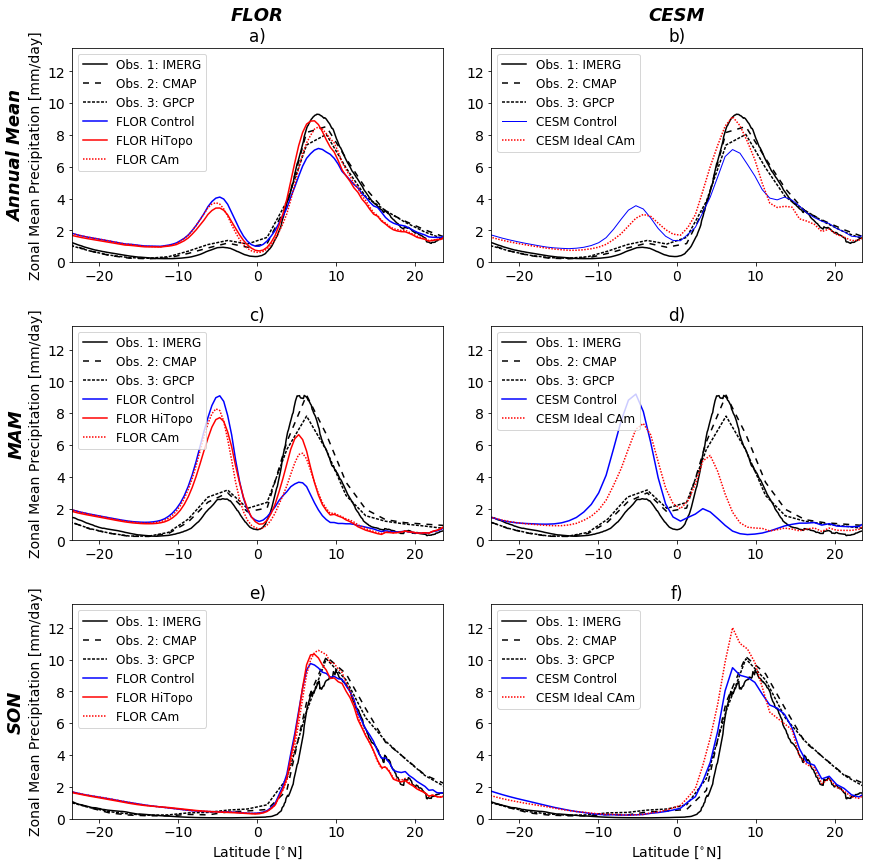

In [13]:
# COMBINED FLOR CESM ZONAL MEAN PRECIPITATION PLOT
fig = plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 14})
fs_legend = 12
fs_label = 18

xlim1 = -23.5
xlim2 = 23.5

ylim1 = 0
ylim2 = 13.5

ax1 = plt.subplot(321)
pac_xtmean_seamask['imerg'].plot(color='black', label = 'Obs. 1: IMERG')
pac_xtmean['cmap'].plot(color='black',dashes = [4,4,4,4], label='Obs. 2: CMAP')
pac_xtmean['gpcp'].plot(color='black',dashes=[2,1,2,1], label='Obs. 3: GPCP')
pac_xtmean_seamask['ctrl'].plot(color='blue', label = 'FLOR Control')
pac_xtmean_seamask['hitopo'].plot(color='red', label = 'FLOR HiTopo')
pac_xtmean_seamask['cam'].plot(color='red',dashes=[1,1,1,1], label = 'FLOR CAm')
ax1.set_title('a)')
ax1.set_ylabel('Zonal Mean Precipitation [mm/day]')
ax1.set_xlabel('')
ax1.set_xlim([xlim1,xlim2])
ax1.set_ylim([ylim1,ylim2])
ax1.legend(fontsize=fs_legend)

ax2 = plt.subplot(322)
pac_xtmean_seamask['imerg'].plot(color='black', label = 'Obs. 1: IMERG')
pac_xtmean['cmap'].plot(color='black',dashes = [4,4,4,4], label='Obs. 2: CMAP')
pac_xtmean['gpcp'].plot(color='black',dashes=[2,1,2,1], label='Obs. 3: GPCP')
pac_xtmean_seamask['cesm_ctrl'].plot(color='blue', linewidth = 1, label = 'CESM Control')
pac_xtmean_seamask['cesm_cam'].plot(color='red',dashes=[1,1,1,1], label = 'CESM Ideal CAm')
ax2.set_title('b)')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlim([xlim1,xlim2])
ax2.set_ylim([ylim1,ylim2])
ax2.legend(fontsize=fs_legend)

ax3 = plt.subplot(323)
seas_pac_xtmean_seamask['imerg'].sel(season='MAM').plot(color='black', label = 'Obs. 1: IMERG')
seas_pac_xtmean['cmap'].sel(season='MAM').plot(color='black',dashes = [4,4,4,4], label='Obs. 2: CMAP')
seas_pac_xtmean['gpcp'].sel(season='MAM').plot(color='black',dashes=[2,1,2,1], label='Obs. 3: GPCP')
seas_pac_xtmean_seamask['ctrl'].sel(season='MAM').plot(color='blue', label = 'FLOR Control')
seas_pac_xtmean_seamask['hitopo'].sel(season='MAM').plot(color='red', label = 'FLOR HiTopo')
seas_pac_xtmean_seamask['cam'].sel(season='MAM').plot(color='red',dashes=[1,1,1,1], label = 'FLOR CAm')
ax3.set_title('c)')
ax3.set_ylabel('Zonal Mean Precipitation [mm/day]')
ax3.set_xlabel('')
ax3.set_xlim([xlim1,xlim2])
ax3.set_ylim([ylim1,ylim2])
ax3.legend(fontsize=fs_legend)

ax4 = plt.subplot(324)
seas_pac_xtmean_seamask['imerg'].sel(season='MAM').plot(color='black', label = 'Obs. 1: IMERG')
seas_pac_xtmean['cmap'].sel(season='MAM').plot(color='black',dashes = [4,4,4,4], label='Obs. 2: CMAP')
seas_pac_xtmean['gpcp'].sel(season='MAM').plot(color='black',dashes=[2,1,2,1], label='Obs. 3: GPCP')
seas_pac_xtmean_seamask['cesm_ctrl'].sel(season='MAM').plot(color='blue', label = 'CESM Control')
seas_pac_xtmean_seamask['cesm_cam'].sel(season='MAM').plot(color='red',dashes=[1,1,1,1],  label = 'CESM Ideal CAm')
ax4.set_title('d)')
ax4.set_xlabel('')
ax4.set_xlim([xlim1,xlim2])
ax4.set_ylim([ylim1,ylim2])
ax4.legend(fontsize=fs_legend)

ax5 = plt.subplot(325)
seas_pac_xtmean_seamask['imerg'].sel(season='SON').plot(color='black', label = 'Obs. 1: IMERG')
seas_pac_xtmean['cmap'].sel(season='SON').plot(color='black',dashes = [4,4,4,4], label='Obs. 2: CMAP')
seas_pac_xtmean['gpcp'].sel(season='SON').plot(color='black',dashes=[2,1,2,1], label='Obs. 3: GPCP')
seas_pac_xtmean_seamask['ctrl'].sel(season='SON').plot(color='blue', label = 'FLOR Control')
seas_pac_xtmean_seamask['hitopo'].sel(season='SON').plot(color='red', label = 'FLOR HiTopo')
seas_pac_xtmean_seamask['cam'].sel(season='SON').plot(color='red',dashes=[1,1,1,1], label = 'FLOR CAm')
ax5.set_title('e)')
ax5.set_ylabel('Zonal Mean Precipitation [mm/day]')
ax5.set_xlabel('Latitude [$^{\circ}$N]')
ax5.set_xlim([xlim1,xlim2])
ax5.set_ylim([ylim1,ylim2])
ax5.legend(fontsize=fs_legend)

ax6 = plt.subplot(326)
seas_pac_xtmean_seamask['imerg'].sel(season='SON').plot(color='black', label = 'Obs. 1: IMERG')
seas_pac_xtmean['cmap'].sel(season='SON').plot(color='black',dashes = [4,4,4,4], label='Obs. 2: CMAP')
seas_pac_xtmean['gpcp'].sel(season='SON').plot(color='black',dashes=[2,1,2,1], label='Obs. 3: GPCP')
seas_pac_xtmean_seamask['cesm_ctrl'].sel(season='SON').plot(color='blue', label = 'CESM Control')
seas_pac_xtmean_seamask['cesm_cam'].sel(season='SON').plot(color='red',dashes=[1,1,1,1], label = 'CESM Ideal CAm')
ax6.set_title('f)')
ax6.set_xlabel('Latitude [$^{\circ}$N]')
ax6.set_xlim([xlim1,xlim2])
ax6.set_ylim([ylim1,ylim2])
ax6.legend(fontsize=fs_legend)

t1 = ax1.text(0.5,1.15,'FLOR',fontsize=fs_label, fontweight='bold', style = 'italic', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
t1b = ax1.text(-0.15,0.5,'Annual Mean',fontsize=fs_label, fontweight='bold', style = 'italic', horizontalalignment='center', verticalalignment='center', rotation = 90, transform=ax1.transAxes)
t2 = ax2.text(0.5,1.15,'CESM',fontsize=fs_label, fontweight='bold', style = 'italic', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
t3 = ax3.text(-0.15,0.5,'MAM',fontsize=fs_label, fontweight='bold', style = 'italic', horizontalalignment='center', verticalalignment='center', rotation = 90, transform=ax3.transAxes)
t5 = ax5.text(-0.15,0.5,'SON',fontsize=fs_label, fontweight='bold', style = 'italic', horizontalalignment='center', verticalalignment='center', rotation = 90, transform=ax5.transAxes)


#plt.suptitle('East Pacific (130W to 75W)')
plt.tight_layout(pad=0.5)

plt.savefig('precip_zonalmean_epac_bothmodels.png',dpi=600)
plt.savefig('precip_zonalmean_epac_bothmodels.pdf')

In [39]:
np.arange(0,13,4)

array([ 0,  4,  8, 12])

In [48]:
# w/ stat sig: FLOR MAPS COMPARING DIFFERENT MODEL RUNS SEASON ZOOMED IN

fig = plt.figure(figsize=(10,9))
plt.rcParams.update({'font.size': 12})

lev = np.arange(0,13,1)
levb = np.arange(0,12,4)
lev2 = np.arange(-4.5,5,0.5)
cmap = cmocean.cm.rain
cmap2 =cmocean.cm.balance_r
cmap2r = cmocean.cm.balance
contour_color = 'darkslategrey'
lw = 0.5
proj = ccrs.PlateCarree(central_longitude=-180)

ymax = 23.5
ymin = -23.5
xmin = 120
xmax = 300

season = 'SON'

ax1 = plt.subplot(5,2,1,projection=proj)
ax1.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im1 = plt.contourf(lonf,latf,seasmean['ctrl'].sel(season=season),levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max')
ax1.coastlines()
ax1.set_title('a) FLOR Control')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax2 = plt.subplot(5,2,2,projection=proj)
ax2.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im2 = plt.contourf(lonf,latf,diff_mask['imerg'][season],levels=lev2,cmap=cmap2,transform=ccrs.PlateCarree(),extend='both')
CS = plt.contour(lonf,latf,seasmean['ctrl'].sel(season=season),levels=levb,transform=ccrs.PlateCarree(),extend='max',colors=contour_color,linewidths=1)
ax2.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax2.coastlines()
ax2.set_title('b) Obs. - FLOR Control')
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax3 = plt.subplot(5,2,3,projection=proj)
ax3.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im3 = plt.contourf(lonc,latc,seasmean['cesm_ctrl'].sel(season=season),levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max',color='k')
ax3.coastlines()
ax3.set_title('c) CESM Control')
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax4 = plt.subplot(5,2,4,projection=proj)
ax4.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im4 = plt.contourf(lonc,latc,diff_mask_cesm['imerg'][season],levels=lev2,cmap=cmap2,transform=ccrs.PlateCarree(),extend='both')
CS = plt.contour(lonc,latc,seasmean['cesm_ctrl'].sel(season=season),levels=levb,transform=ccrs.PlateCarree(),extend='max',colors=contour_color,linewidths=1)
ax4.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax4.coastlines()
ax4.set_title('d) Obs. - CESM Control')
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax5 = plt.subplot(5,2,5,projection=proj)
ax5.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im5 = plt.contourf(lonf,latf,seasmean['hitopo'].sel(season=season),levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max')
ax5.coastlines()
ax5.set_title('e) FLOR HiTopo')
gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax6 = plt.subplot(5,2,6,projection=proj)
ax6.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im6 = plt.contourf(lonf,latf,diff_mask['hitopo'][season],levels=lev2,cmap=cmap2,transform=ccrs.PlateCarree(),extend='both')
CS = plt.contour(lonf,latf,seasmean['ctrl'].sel(season=season),levels=levb,transform=ccrs.PlateCarree(),extend='max',colors=contour_color,linewidths=1)
ax6.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax6.coastlines()
ax6.set_title('f) FLOR HiTopo - FLOR Control')
gl = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax7 = plt.subplot(5,2,7,projection=proj)
ax7.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im7 = plt.contourf(lonf,latf,seasmean['cam'].sel(season=season),levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max')
ax7.coastlines()
ax7.set_title('g) FLOR CAm')
gl = ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax8 = plt.subplot(5,2,8,projection=proj)
ax8.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im8 = plt.contourf(lonf,latf,diff_mask['cam'][season],levels=lev2,cmap=cmap2,transform=ccrs.PlateCarree(),extend='both')
CS = plt.contour(lonf,latf,seasmean['ctrl'].sel(season=season),levels=levb,transform=ccrs.PlateCarree(),extend='max',colors=contour_color,linewidths=1)
ax8.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax8.coastlines()
ax8.set_title('h) FLOR CAm - FLOR Control')
gl = ax8.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax9 = plt.subplot(5,2,9,projection=proj)
ax9.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im9 = plt.contourf(lonc,latc,seasmean['cesm_cam'].sel(season=season),levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max')
ax9.coastlines()
ax9.set_title('i) CESM Ideal CAm')
gl = ax9.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax10 = plt.subplot(5,2,10,projection=proj)
ax10.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im10 = plt.contourf(lonc,latc,diff_mask['cesm_cam'][season],levels=lev2,cmap=cmap2,transform=ccrs.PlateCarree(),extend='both')
CS = plt.contour(lonc,latc,seasmean['cesm_ctrl'].sel(season=season),levels=levb,transform=ccrs.PlateCarree(),extend='max',colors=contour_color,linewidths=1)
ax10.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax10.coastlines()
ax10.set_title('j) CESM Ideal CAm - CESM Control')
gl = ax10.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.15, 0.07, 0.3, 0.02]) # rect = l, b, w, h
cb1 = fig.colorbar(im1, cax=cb1_ax, orientation = 'horizontal')
cb1.ax.set_xlabel('precipitation [mm/day]', rotation=0)

cb2_ax = fig.add_axes([0.57, 0.07, 0.3, 0.02])
cb2 = fig.colorbar(im2, cax=cb2_ax, orientation = 'horizontal')
cb2.ax.set_xlabel('precipitation [mm/day]', rotation=0)

#plt.tight_layout()

plt.savefig('precip_map_'+season+'_zoom.pdf')


/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'color'
  s)


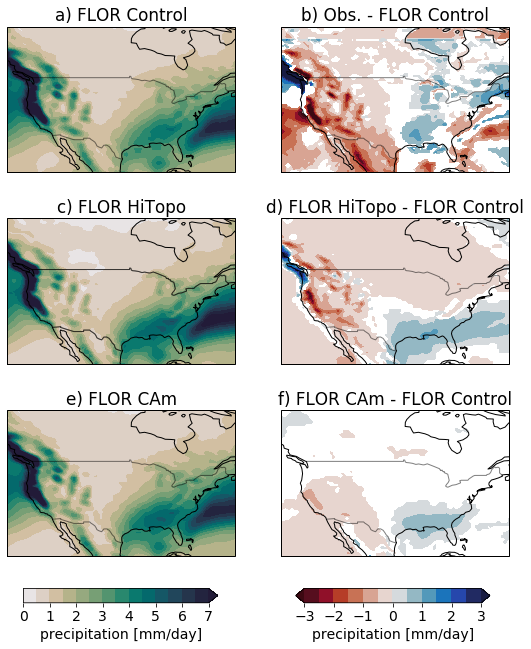

In [20]:
# w/ stat sig: North America DJF

fig = plt.figure(figsize=(9,10))
plt.rcParams.update({'font.size': 14})

lev = np.arange(0,7.5,0.5)
lev2 = np.arange(-3,3.5,0.5)
cmap = cmocean.cm.rain
cmap2 =cmocean.cm.balance_r
cmap2r = cmocean.cm.balance
proj = ccrs.PlateCarree(central_longitude=-180)

xmin = -130
xmax = -65
ymin = 22
ymax = 60

season = 'DJF'

ax1 = plt.subplot(3,2,1,projection=proj)
im1 = plt.contourf(lonf,latf,seasmean['ctrl'].sel(season=season),levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max')
ax1.coastlines()
ax1.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax1.set_title('a) FLOR Control')
ax1.set_extent([xmin, xmax, ymin, ymax])

ax2 = plt.subplot(3,2,2,projection=proj)
im2 = plt.contourf(lonf,latf,diff_mask['imerg'][season],levels=lev2,cmap=cmap2,transform=ccrs.PlateCarree(),extend='both')
ax2.coastlines()
ax2.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax2.set_title('b) Obs. - FLOR Control')
ax2.set_extent([xmin, xmax, ymin, ymax])

ax3 = plt.subplot(3,2,3,projection=proj)
im1 = plt.contourf(lonf,latf,seasmean['hitopo'].sel(season=season),levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max')
ax3.coastlines()
ax3.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax3.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax3.set_title('c) FLOR HiTopo')
ax3.set_extent([xmin, xmax, ymin, ymax])

ax4 = plt.subplot(3,2,4,projection=proj)
im4 = plt.contourf(lonf,latf,diff_mask['hitopo'][season],levels=lev2,cmap=cmap2,transform=ccrs.PlateCarree(),extend='both')
ax4.coastlines()
ax4.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax4.set_title('d) FLOR HiTopo - FLOR Control')
ax4.set_extent([xmin, xmax, ymin, ymax])

ax5 = plt.subplot(3,2,5,projection=proj)
im1 = plt.contourf(lonf,latf,seasmean['cam'].sel(season=season),levels=lev,cmap=cmap,transform=ccrs.PlateCarree(),extend='max')
ax5.coastlines()
ax5.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax5.set_title('e) FLOR CAm')
ax5.set_extent([xmin, xmax, ymin, ymax])

ax6 = plt.subplot(3,2,6,projection=proj)
im6 = plt.contourf(lonf,latf,diff_mask['cam'][season],levels=lev2,cmap=cmap2,transform=ccrs.PlateCarree(),extend='both')
ax6.coastlines()
ax6.add_feature(feature.BORDERS, linestyle='-', alpha=.5)
ax6.set_title('f) FLOR CAm - FLOR Control')
ax6.set_extent([xmin, xmax, ymin, ymax])

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.15, 0.07, 0.3, 0.02]) # rect = l, b, w, h
cb1 = fig.colorbar(im1, cax=cb1_ax, orientation = 'horizontal')
cb1.ax.set_xlabel('precipitation [mm/day]', rotation=0)

cb2_ax = fig.add_axes([0.57, 0.07, 0.3, 0.02])
cb2 = fig.colorbar(im2, cax=cb2_ax, orientation = 'horizontal')
cb2.ax.set_xlabel('precipitation [mm/day]', rotation=0)


#plt.tight_layout(w_pad = 7)

plt.savefig('us_precip_map_djf.png',dpi = 600)
plt.savefig('us_precip_map_djf.pdf')

# Plots below here are not in paper.

In [15]:
# MAPS COMPARING DIFFERENT MODEL RUNS

fig = plt.figure(figsize=(10,8))

lev = np.arange(0,13,1)
lev2 = np.arange(-4.5,5,0.5)
cmap = cmocean.cm.rain
cmap2 =cmocean.cm.balance_r
cmap2r = cmocean.cm.balance
proj = ccrs.Mollweide(central_longitude=-180)

ax1 = plt.subplot(3,2,1,projection=proj)
im1 = tmean['ctrl'].plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax1.coastlines()
ax1.set_title('a) Control')

ax2 = plt.subplot(3,2,2,projection=proj)
im2 = diff['imerg']['ctrl'].plot(ax=ax2, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree(), add_colorbar = False)
ax2.coastlines()
ax2.set_title('b) Obs. - Control')

ax3 = plt.subplot(3,2,3,projection=proj)
tmean['hitopo'].plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax3.coastlines()
ax3.set_title('c) HiTopo')

ax4 = plt.subplot(3,2,4,projection=proj)
mdiff['hitopo'].plot(ax=ax4, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax4.coastlines()
ax4.set_title('d) HiTopo - Control')

ax5 = plt.subplot(3,2,5,projection=proj)
tmean['cam'].plot(ax=ax5, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax5.coastlines()
ax5.set_title('e) CAm')

ax6 = plt.subplot(3,2,6,projection=proj)
mdiff['cam'].plot(ax=ax6, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax6.coastlines()
ax6.set_title('f) CAm - Control')

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.47, 0.50, 0.02, 0.4])
cb1 = fig.colorbar(im1, cax=cb1_ax)
cb1.ax.set_ylabel('precipitation [mm/day]', rotation=90, fontsize=12)

cb2_ax = fig.add_axes([0.47, 0.05, 0.02, 0.4])
cb2 = fig.colorbar(im2, cax=cb2_ax)
cb2.ax.set_ylabel('precipitation [mm/day]', rotation=90, fontsize=12)

plt.tight_layout(w_pad = 7)

plt.savefig('precip_map.png',dpi = 600)


/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


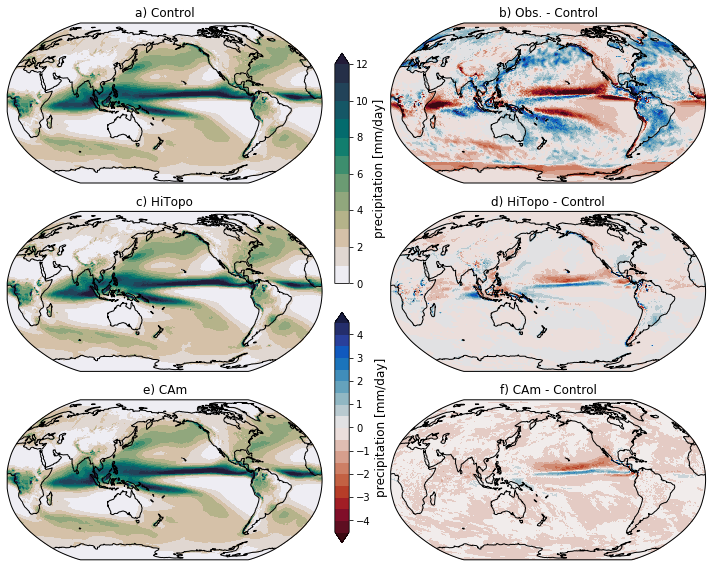

In [74]:
# FLOR MAPS COMPARING DIFFERENT MODEL RUNS SEASON

fig = plt.figure(figsize=(10,8))

lev = np.arange(0,13,1)
lev2 = np.arange(-4.5,5,0.5)
cmap = cmocean.cm.rain
cmap2 =cmocean.cm.balance_r
cmap2r = cmocean.cm.balance
proj = ccrs.Robinson(central_longitude=-180)

season = 'MAM'

ax1 = plt.subplot(3,2,1,projection=proj)
im1 = seasmean['ctrl'].sel(season=season).plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax1.coastlines()
ax1.set_title('a) Control')

ax2 = plt.subplot(3,2,2,projection=proj)
im2 = seas_diff['imerg']['ctrl'].sel(season=season).plot(ax=ax2, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree(), add_colorbar = False)
ax2.coastlines()
ax2.set_title('b) Obs. - Control')

ax3 = plt.subplot(3,2,3,projection=proj)
seasmean['hitopo'].sel(season=season).plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax3.coastlines()
ax3.set_title('c) HiTopo')

ax4 = plt.subplot(3,2,4,projection=proj)
seas_mdiff['hitopo'].sel(season=season).plot(ax=ax4, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax4.coastlines()
ax4.set_title('d) HiTopo - Control')

ax5 = plt.subplot(3,2,5,projection=proj)
seasmean['cam'].sel(season=season).plot(ax=ax5, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax5.coastlines()
ax5.set_title('e) CAm')

ax6 = plt.subplot(3,2,6,projection=proj)
seas_mdiff['cam'].sel(season=season).plot(ax=ax6, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax6.coastlines()
ax6.set_title('f) CAm - Control')

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.47, 0.50, 0.02, 0.4])
cb1 = fig.colorbar(im1, cax=cb1_ax)
cb1.ax.set_ylabel('precipitation [mm/day]', rotation=90, fontsize=12)

cb2_ax = fig.add_axes([0.47, 0.05, 0.02, 0.4])
cb2 = fig.colorbar(im2, cax=cb2_ax)
cb2.ax.set_ylabel('precipitation [mm/day]', rotation=90, fontsize=12)

plt.tight_layout(w_pad = 7)

#plt.savefig('precip_map_'+season+'.png',dpi = 600)
plt.savefig('precip_map_'+season+'.pdf',dpi = 600)



In [75]:
# CESM MAPS COMPARING DIFFERENT MODEL RUNS

fig = plt.figure(figsize=(10,6))

lev = np.arange(0,13,1)
lev2 = np.arange(-4.5,5,0.5)
cmap = cmocean.cm.rain
cmap2 =cmocean.cm.balance_r
cmap2r = cmocean.cm.balance
proj = ccrs.Robinson(central_longitude=180)

season = 'MAM'
lonmin = seasmean['cesm_ctrl'].sel(season=season).lon.min()
lonmax = seasmean['cesm_ctrl'].sel(season=season).lon.max()

ax1 = plt.subplot(2,2,1,projection=proj)
ax1.set_extent([lonmin, lonmax, -90, 90], ccrs.PlateCarree())
im1 = seasmean['cesm_ctrl'].sel(season=season).plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax1.coastlines()
ax1.set_title('a) CESM Control')

ax2 = plt.subplot(2,2,2,projection=proj)
ax2.set_extent([lonmin, lonmax, -90, 90], ccrs.PlateCarree())
im2 = seas_diff['imerg']['cesm_ctrl'].sel(season=season).plot(ax=ax2, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree(), add_colorbar = False)
ax2.coastlines()
ax2.set_title('b) Obs. - CESM Control')

ax3 = plt.subplot(2,2,3,projection=proj)
ax3.set_extent([lonmin, lonmax, -90, 90], ccrs.PlateCarree())
seasmean['cesm_cam'].sel(season=season).plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax3.coastlines()
ax3.set_title('c) CESM Ideal CAm')

ax4 = plt.subplot(2,2,4,projection=proj)
ax4.set_extent([lonmin, lonmax, -90, 90], ccrs.PlateCarree())
seas_mdiff['cesm_cam'].sel(season=season).plot(ax=ax4, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax4.coastlines()
ax4.set_title('d) CESM Ideal CAm - CESM Control')

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.47, 0.50, 0.02, 0.4])
cb1 = fig.colorbar(im1, cax=cb1_ax)
cb1.ax.set_ylabel('precipitation [mm/day]', rotation=90, fontsize=12)

cb2_ax = fig.add_axes([0.47, 0.05, 0.02, 0.4])
cb2 = fig.colorbar(im2, cax=cb2_ax)
cb2.ax.set_ylabel('precipitation [mm/day]', rotation=90, fontsize=12)

plt.tight_layout(w_pad = 7)

#plt.savefig('precip_map_'+season+'_cesm.png',dpi = 600)
plt.savefig('precip_map_'+season+'_cesm.pdf')



/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:745: RuntimeWarning: invalid value encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:746: RuntimeWarning: invalid value encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:747: RuntimeWarning: invalid value encountered in maximum
  y0 = np.maximum(bbox1.ymi

In [36]:
# FLOR MAPS COMPARING DIFFERENT MODEL RUNS SEASON ZOOMED IN

fig = plt.figure(figsize=(10,9))

lev = np.arange(0,13,1)
lev2 = np.arange(-4.5,5,0.5)
cmap = cmocean.cm.rain
cmap2 =cmocean.cm.balance_r
cmap2r = cmocean.cm.balance
proj = ccrs.Mollweide(central_longitude=-180)

ymax = 23.5
ymin = -23.5
xmin = 120
xmax = 300

season = 'SON'

ax1 = plt.subplot(5,2,1,projection=proj)
ax1.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im1 = seasmean['ctrl'].sel(season=season).plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax1.coastlines()
ax1.set_title('a) Control')

ax2 = plt.subplot(5,2,2,projection=proj)
ax2.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im2 = seas_diff['imerg']['ctrl'].sel(season=season).plot(ax=ax2, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree(), add_colorbar = False)
ax2.coastlines()
ax2.set_title('b) Obs. - Control')

ax3 = plt.subplot(5,2,3,projection=proj)
ax3.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im3 = seasmean['cesm_ctrl'].sel(season=season).plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax3.coastlines()
ax3.set_title('c) CESM Control')

ax4 = plt.subplot(5,2,4,projection=proj)
ax4.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
im4 = seas_diff['imerg']['cesm_ctrl'].sel(season=season).plot(ax=ax4, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree(), add_colorbar = False)
ax4.coastlines()
ax4.set_title('d) Obs. - CESM Control')

ax5 = plt.subplot(5,2,5,projection=proj)
ax5.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
seasmean['hitopo'].sel(season=season).plot(ax=ax5, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax5.coastlines()
ax5.set_title('e) HiTopo')

ax6 = plt.subplot(5,2,6,projection=proj)
ax6.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
seas_mdiff['hitopo'].sel(season=season).plot(ax=ax6, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax6.coastlines()
ax6.set_title('f) HiTopo - Control')

ax7 = plt.subplot(5,2,7,projection=proj)
ax7.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
seasmean['cam'].sel(season=season).plot(ax=ax7, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax7.coastlines()
ax7.set_title('g) CAm')

ax8 = plt.subplot(5,2,8,projection=proj)
ax8.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
seas_mdiff['cam'].sel(season=season).plot(ax=ax8, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax8.coastlines()
ax8.set_title('h) CAm - Control')

ax9 = plt.subplot(5,2,9,projection=proj)
ax9.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
seasmean['cesm_cam'].sel(season=season).plot(ax=ax9, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax9.coastlines()
ax9.set_title('i) CESM Ideal CAm')

ax10 = plt.subplot(5,2,10,projection=proj)
ax10.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
seas_mdiff['cesm_cam'].sel(season=season).plot(ax=ax10, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax10.coastlines()
ax10.set_title('j) CESM Ideal CAm - CESM Control')

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.15, 0.07, 0.3, 0.02]) # rect = l, b, w, h
cb1 = fig.colorbar(im1, cax=cb1_ax, orientation = 'horizontal')
cb1.ax.set_xlabel('precipitation [mm/day]', rotation=0, fontsize=12)

cb2_ax = fig.add_axes([0.57, 0.07, 0.3, 0.02])
cb2 = fig.colorbar(im2, cax=cb2_ax, orientation = 'horizontal')
cb2.ax.set_xlabel('precipitation [mm/day]', rotation=0, fontsize=12)

#plt.tight_layout(w_pad = 0)

plt.savefig('precip_map_'+season+'_zoom.pdf')


/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:745: RuntimeWarning: invalid value encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:746: RuntimeWarning: invalid value encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:747: RuntimeWarning: invalid value encountered in maximum
  y0 = np.maximum(bbox1.ymin, bbox2.ymin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:748: RuntimeWarning: invalid value encountered in minimum
  y1 = np.minimum(bbox1.ymax, bbox2.ymax)


In [78]:
# CESM MAPS COMPARING DIFFERENT MODEL RUNS SON ZOOMED IN

fig = plt.figure(figsize=(13,5))

lev = np.arange(0,13,1)
lev2 = np.arange(-4.5,5,0.5)
cmap = cmocean.cm.rain
cmap2 =cmocean.cm.balance_r
cmap2r = cmocean.cm.balance
proj = ccrs.Mollweide(central_longitude=-180)

season = 'MAM'

ax1 = plt.subplot(2,2,1,projection=proj)
ax1.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im1 = seasmean['cesm_ctrl'].sel(season=season).plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax1.coastlines()
ax1.set_title('a) CESM Control')

ax2 = plt.subplot(2,2,2,projection=proj)
ax2.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
im2 = seas_diff['imerg']['cesm_ctrl'].sel(season=season).plot(ax=ax2, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree(), add_colorbar = False)
ax2.coastlines()
ax2.set_title('b) Obs. - CESM Control')

ax3 = plt.subplot(2,2,3,projection=proj)
ax3.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
seasmean['cesm_cam'].sel(season=season).plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar = False)
ax3.coastlines()
ax3.set_title('c) CESM CAm')

ax4 = plt.subplot(2,2,4,projection=proj)
ax4.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
seas_mdiff['cesm_cam'].sel(season=season).plot(ax=ax4, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree(), add_colorbar = False)
ax4.coastlines()
ax4.set_title('d) CESM CAm - CESM Control')

#fig.subplots_adjust(wspace=0.7)
cb1_ax = fig.add_axes([0.48, 0.53, 0.02, 0.35])
cb1 = fig.colorbar(im1, cax=cb1_ax)
cb1.ax.set_ylabel('precipitation [mm/day]', rotation=90, fontsize=12)

cb2_ax = fig.add_axes([0.48, 0.13, 0.02, 0.35])
cb2 = fig.colorbar(im2, cax=cb2_ax)
cb2.ax.set_ylabel('precipitation [mm/day]', rotation=90, fontsize=12)

#plt.tight_layout()

plt.savefig('precip_map_'+season+'_zoom_cesm.pdf')


/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:745: RuntimeWarning: invalid value encountered in maximum
  x0 = np.maximum(bbox1.xmin, bbox2.xmin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:746: RuntimeWarning: invalid value encountered in minimum
  x1 = np.minimum(bbox1.xmax, bbox2.xmax)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:747: RuntimeWarning: invalid value encountered in maximum
  y0 = np.maximum(bbox1.ymin, bbox2.ymin)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/matplotlib/transforms.py:748: RuntimeWarning: invalid value encountered in minimum
  y1 = np.minimum(bbox1.ymax, bbox2.ymax)


KeyError: 'cmap'

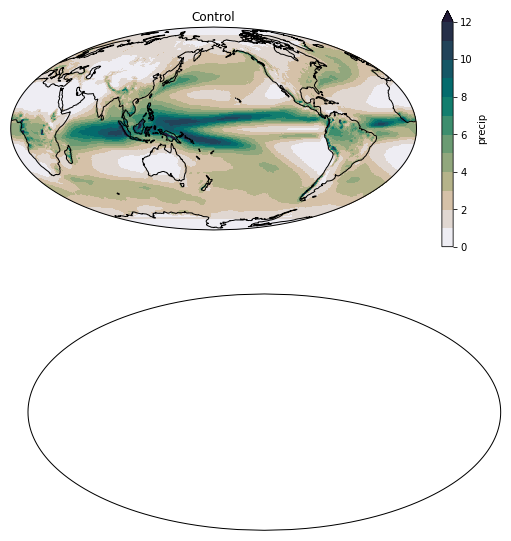

In [114]:
# MAPS COMPARING CONTROL AND OBS

fig = plt.figure(figsize=(20,20))

lev = np.arange(0,13,1)
lev2 = np.arange(-5,5.5,0.5)
cmap = cmocean.cm.rain
cmap2 =cmocean.cm.balance_r
proj = ccrs.Mollweide(central_longitude=180)

ax1 = plt.subplot(4,2,1,projection=proj)
tmean['ctrl'].plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title('Control')

ax3 = plt.subplot(4,2,3,projection=proj)
tmean['cmap'].plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('Obs. 1: CMAP')

ax4 = plt.subplot(4,2,4,projection=proj)
diff['cmap'].plot(ax=ax4, levels = lev2,cmap = cmap2, transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.set_title('Control - CMAP')

ax5 = plt.subplot(4,2,5,projection=proj)
tmean['gpcp'].plot(ax=ax5, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax5.coastlines()
ax5.set_title('Obs. 2: GPCP')

ax6 = plt.subplot(4,2,6,projection=proj)
diff['gpcp'].plot(ax=ax6, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree())
ax6.coastlines()
ax6.set_title('Control - GPCP')

ax7 = plt.subplot(4,2,7,projection=proj)
tmean['imerg'].plot(ax=ax7, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax7.coastlines()
ax7.set_title('Obs. 3: IMERG')

ax8 = plt.subplot(4,2,8,projection=proj)
diff['imerg'].plot(ax=ax8, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree())
ax8.coastlines()
ax8.set_title('Control - IMERG')

plt.tight_layout()

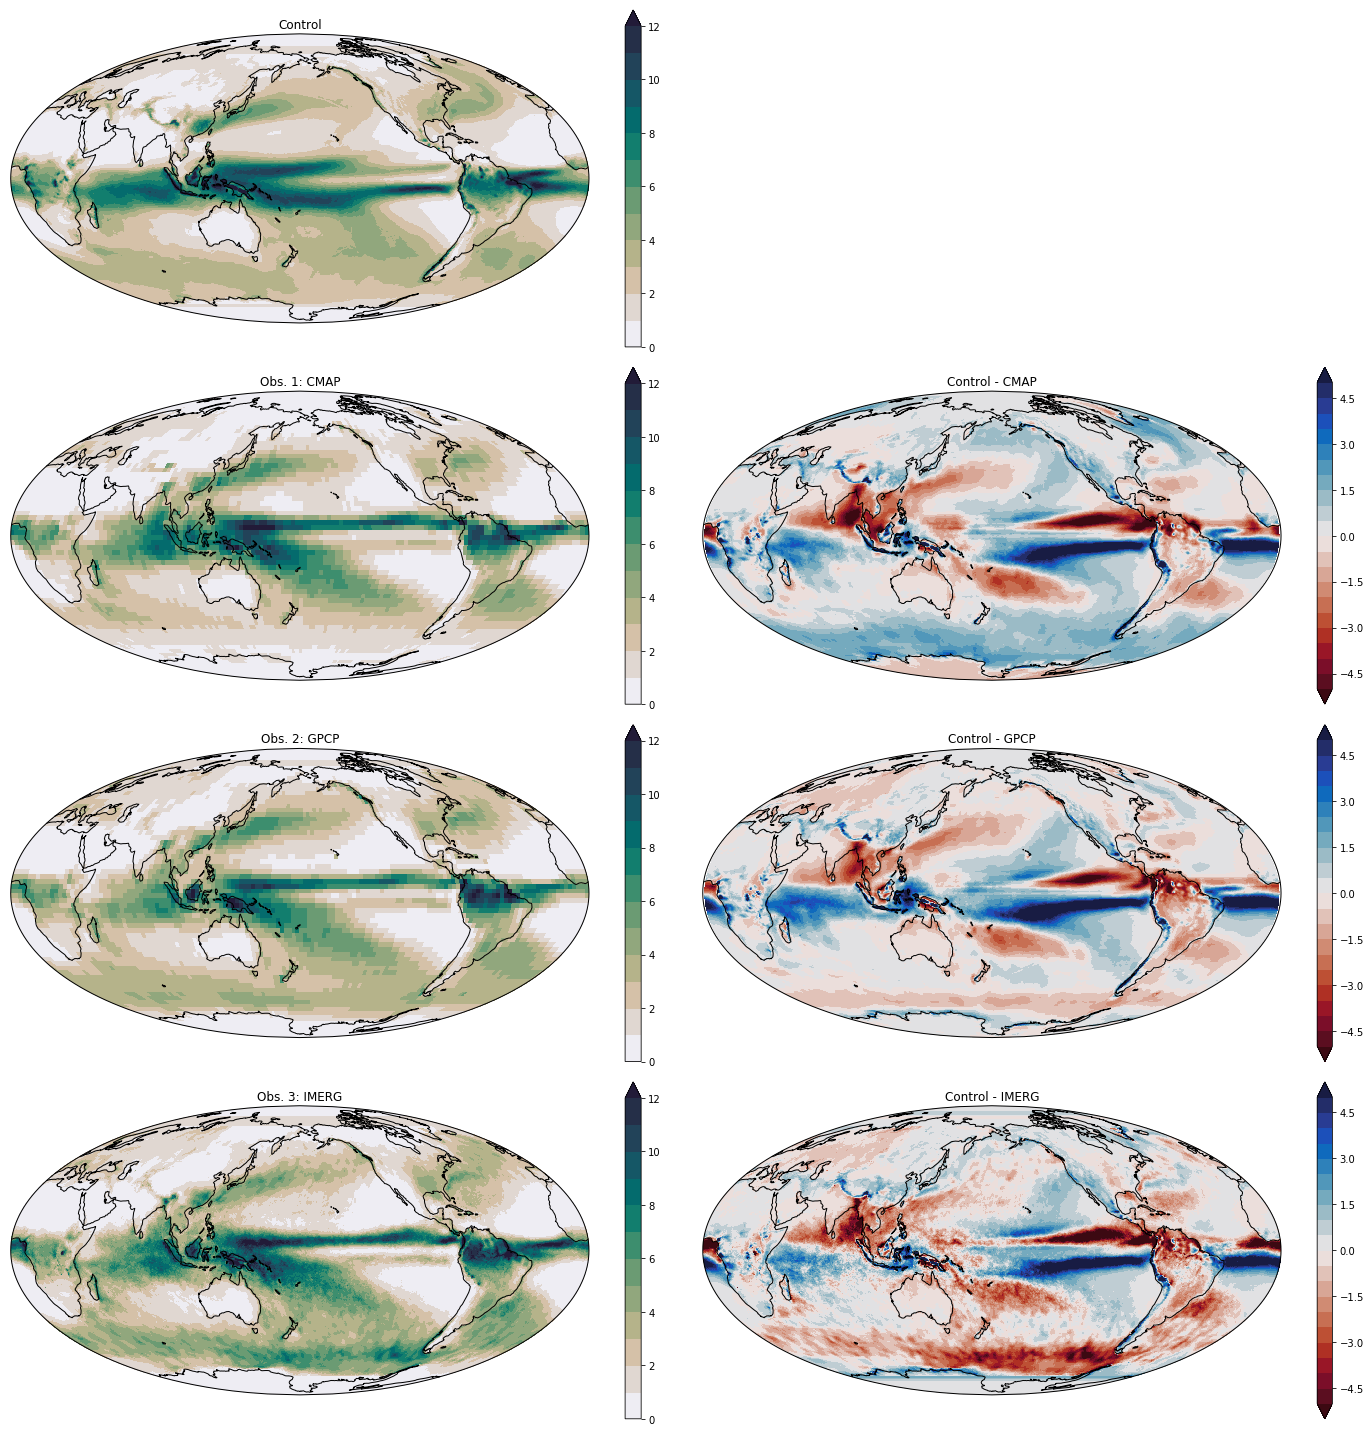

In [171]:
# MAP COMPARING MODEL AND OBS MAM

fig = plt.figure(figsize=(20,20))

lev = np.arange(0,13,1)
lev2 = np.arange(-5,5.5,0.5)
cmap = cmocean.cm.rain
cmap2 =cmocean.cm.balance_r
proj = ccrs.Mollweide(central_longitude=180)

ax1 = plt.subplot(4,2,1,projection=proj)
seasmean['ctrl'].sel(season='MAM').plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title('Control')

ax3 = plt.subplot(4,2,3,projection=proj)
seasmean['cmap'].sel(season='MAM').plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('Obs. 1: CMAP')

ax4 = plt.subplot(4,2,4,projection=proj)
seas_diff['cmap'].sel(season='MAM').plot(ax=ax4, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.set_title('Control - CMAP')

ax5 = plt.subplot(4,2,5,projection=proj)
seasmean['gpcp'].sel(season='MAM').plot(ax=ax5, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax5.coastlines()
ax5.set_title('Obs. 2: GPCP')

ax6 = plt.subplot(4,2,6,projection=proj)
seas_diff['gpcp'].sel(season='MAM').plot(ax=ax6, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree())
ax6.coastlines()
ax6.set_title('Control - GPCP')

ax7 = plt.subplot(4,2,7,projection=proj)
seasmean['imerg'].sel(season='MAM').plot(ax=ax7, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax7.coastlines()
ax7.set_title('Obs. 3: IMERG')

ax8 = plt.subplot(4,2,8,projection=proj)
seas_diff['imerg'].sel(season='MAM').plot(ax=ax8, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree())
ax8.coastlines()
ax8.set_title('Control - IMERG')

plt.tight_layout()

In [123]:
# Zonal mean precipitation

fig = plt.figure(figsize=(10,7))

xlim1 = -23.5
xlim2 = 23.5

ax1 = plt.subplot(2,2,1)
#xtmean['gpcp'].plot(color='black',label='Obs. 1: GPCP')
#xtmean['cmap'].plot(color='black',dashes=[4,4,4,4], label = 'Obs. 2: CMAP')
xtmean['imerg'].plot(color='black',dashes=[1,1,1,1], label = 'Obs. 3: IMERG')
xtmean['ctrl'].plot(color='blue', label = 'Control')
xtmean['hitopo'].plot(color='red', label = 'HiTopo')
xtmean['cam'].plot(color='red',dashes=[1,1,1,1], label = 'CAM')
ax1.set_title('Global')
ax1.set_ylabel('Zonal Mean Precipitation [mm/day]')
ax1.set_xlim([xlim1,xlim2])
ax1.legend()

ax2 = plt.subplot(2,2,2)
pac_xtmean['gpcp'].plot(color='black')
pac_xtmean['cmap'].plot(color='black',dashes=[4,4,4,4])
pac_xtmean['imerg'].plot(color='black',dashes=[1,1,1,1])
pac_xtmean['ctrl'].plot(color='blue')
pac_xtmean['hitopo'].plot(color='red')
pac_xtmean['cam'].plot(color='red',dashes=[1,1,1,1])
ax2.set_title('Pacific (130W to 90W)')
ax2.set_ylabel('Zonal Mean Precipitation [mm/day]')
ax2.set_xlim([xlim1,xlim2])

ax3 = plt.subplot(2,2,3)
seas_xtmean['gpcp'].sel(season='MAM').plot(color='black')
seas_xtmean['cmap'].sel(season='MAM').plot(color='black',dashes=[4,4,4,4])
seas_xtmean['imerg'].sel(season='MAM').plot(color='black',dashes=[1,1,1,1])
seas_xtmean['ctrl'].sel(season='MAM').plot(color='blue')
seas_xtmean['hitopo'].sel(season='MAM').plot(color='red')
seas_xtmean['cam'].sel(season='MAM').plot(color='red',dashes=[1,1,1,1])
ax3.set_title('Global MAM')
ax3.set_ylabel('Zonal Mean Precipitation [mm/day]')
ax3.set_xlim([xlim1,xlim2])

ax4 = plt.subplot(2,2,4)
#seas_pac_xtmean['gpcp'].sel(season='MAM').plot(color='black', label='Obs. 1: GPCP')
#seas_pac_xtmean['cmap'].sel(season='MAM').plot(color='black',dashes=[4,4,4,4], label='Obs. 2: CMAP')
seas_pac_xtmean['imerg'].sel(season='MAM').plot(color='black', label = 'Obs.: IMERG',linewidth=2.5)
seas_pac_xtmean['ctrl'].sel(season='MAM').plot(color='blue', label = 'Control')
seas_pac_xtmean['hitopo'].sel(season='MAM').plot(color='red', label = 'HiTopo')
seas_pac_xtmean['cam'].sel(season='MAM').plot(color='red',dashes=[1,1,1,1], label = 'CAm')
ax4.set_title('East Pacific (130W to 75W) MAM')
ax4.set_ylabel('Zonal Mean Precipitation [mm/day]')
ax4.set_xlabel('Latitude [deg N]')
ax4.set_xlim([xlim1,xlim2])
ax4.legend()

plt.tight_layout()
plt.savefig('precip_zonalmean.png',dpi=600)

(-23.5, 23.5)

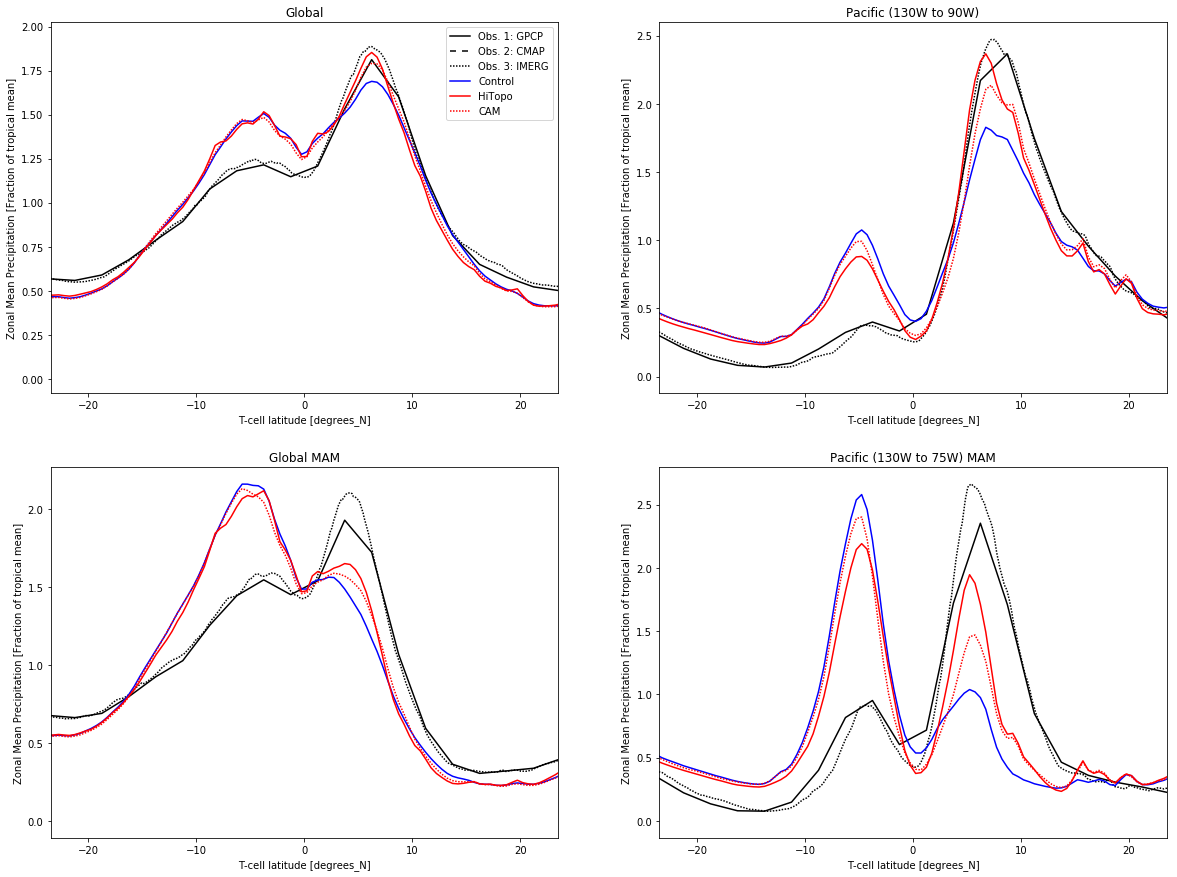

In [111]:
# Zonal mean precipitation normalized by tropical mean precipitation

fig = plt.figure(figsize=(20,15))

xlim1 = -23.5
xlim2 = 23.5

ax1 = plt.subplot(2,2,1)
xtmean_norm['gpcp'].plot(color='black',label='Obs. 1: GPCP')
xtmean_norm['cmap'].plot(color='black',dashes=[4,4,4,4], label = 'Obs. 2: CMAP')
xtmean_norm['imerg'].plot(color='black',dashes=[1,1,1,1], label = 'Obs. 3: IMERG')
xtmean_norm['ctrl'].plot(color='blue', label = 'Control')
xtmean_norm['hitopo'].plot(color='red', label = 'HiTopo')
xtmean_norm['cam'].plot(color='red',dashes=[1,1,1,1], label = 'CAM')
ax1.set_title('Global')
ax1.set_ylabel('Zonal Mean Precipitation [Fraction of tropical mean]')
ax1.set_xlim([xlim1,xlim2])
ax1.legend()

ax2 = plt.subplot(2,2,2)
pac_xtmean_norm['gpcp'].plot(color='black')
pac_xtmean_norm['cmap'].plot(color='black',dashes=[4,4,4,4])
pac_xtmean_norm['imerg'].plot(color='black',dashes=[1,1,1,1])
pac_xtmean_norm['ctrl'].plot(color='blue')
pac_xtmean_norm['hitopo'].plot(color='red')
pac_xtmean_norm['cam'].plot(color='red',dashes=[1,1,1,1])
ax2.set_title('Pacific (130W to 90W)')
ax2.set_ylabel('Zonal Mean Precipitation [Fraction of tropical mean]')
ax2.set_xlim([xlim1,xlim2])

ax3 = plt.subplot(2,2,3)
seas_xtmean_norm['gpcp'].sel(season='MAM').plot(color='black')
seas_xtmean_norm['cmap'].sel(season='MAM').plot(color='black',dashes=[4,4,4,4])
seas_xtmean_norm['imerg'].sel(season='MAM').plot(color='black',dashes=[1,1,1,1])
seas_xtmean_norm['ctrl'].sel(season='MAM').plot(color='blue')
seas_xtmean_norm['hitopo'].sel(season='MAM').plot(color='red')
seas_xtmean_norm['cam'].sel(season='MAM').plot(color='red',dashes=[1,1,1,1])
ax3.set_title('Global MAM')
ax3.set_ylabel('Zonal Mean Precipitation [Fraction of tropical mean]')
ax3.set_xlim([xlim1,xlim2])

ax4 = plt.subplot(2,2,4)
seas_pac_xtmean_norm['gpcp'].sel(season='MAM').plot(color='black')
seas_pac_xtmean_norm['cmap'].sel(season='MAM').plot(color='black',dashes=[4,4,4,4])
seas_pac_xtmean_norm['imerg'].sel(season='MAM').plot(color='black',dashes=[1,1,1,1])
seas_pac_xtmean_norm['ctrl'].sel(season='MAM').plot(color='blue')
seas_pac_xtmean_norm['hitopo'].sel(season='MAM').plot(color='red')
seas_pac_xtmean_norm['cam'].sel(season='MAM').plot(color='red',dashes=[1,1,1,1])
ax4.set_title('Pacific (130W to 75W) MAM')
ax4.set_ylabel('Zonal Mean Precipitation [Fraction of tropical mean]')
ax4.set_xlim([xlim1,xlim2])

In [76]:
# MAPS COMPARING DIFFERENT MODEL RUNS MAM

fig = plt.figure(figsize=(20,20))

lev = np.arange(0,13,1)
lev2 = np.arange(-5,5.5,0.5)
cmap = cmocean.cm.rain
cmap2 = cmocean.cm.balance_r
cmap2r = cmocean.cm.balance
proj = ccrs.Mollweide(central_longitude=180)

ax1 = plt.subplot(4,2,1,projection=proj)
seasmean['ctrl'].sel(season='MAM').plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title('Control')

ax2 = plt.subplot(4,2,2,projection=proj)
seas_diff['imerg']['ctrl'].sel(season='MAM').plot(ax=ax2, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title('Control - Obs.')

ax3 = plt.subplot(4,2,3,projection=proj)
seasmean['cam'].sel(season='MAM').plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('CAM')

ax4 = plt.subplot(4,2,4,projection=proj)
seas_mdiff['cam'].sel(season='MAM').plot(ax=ax4, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.set_title('Control - CAM')

ax5 = plt.subplot(4,2,5,projection=proj)
seasmean['hitopo'].sel(season='MAM').plot(ax=ax5, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax5.coastlines()
ax5.set_title('HiTopo')

ax6 = plt.subplot(4,2,6,projection=proj)
seas_mdiff['hitopo'].sel(season='MAM').plot(ax=ax6, levels = lev2, cmap = cmap2r, transform=ccrs.PlateCarree())
ax6.coastlines()
ax6.set_title('Control - HiTopo')

plt.tight_layout()

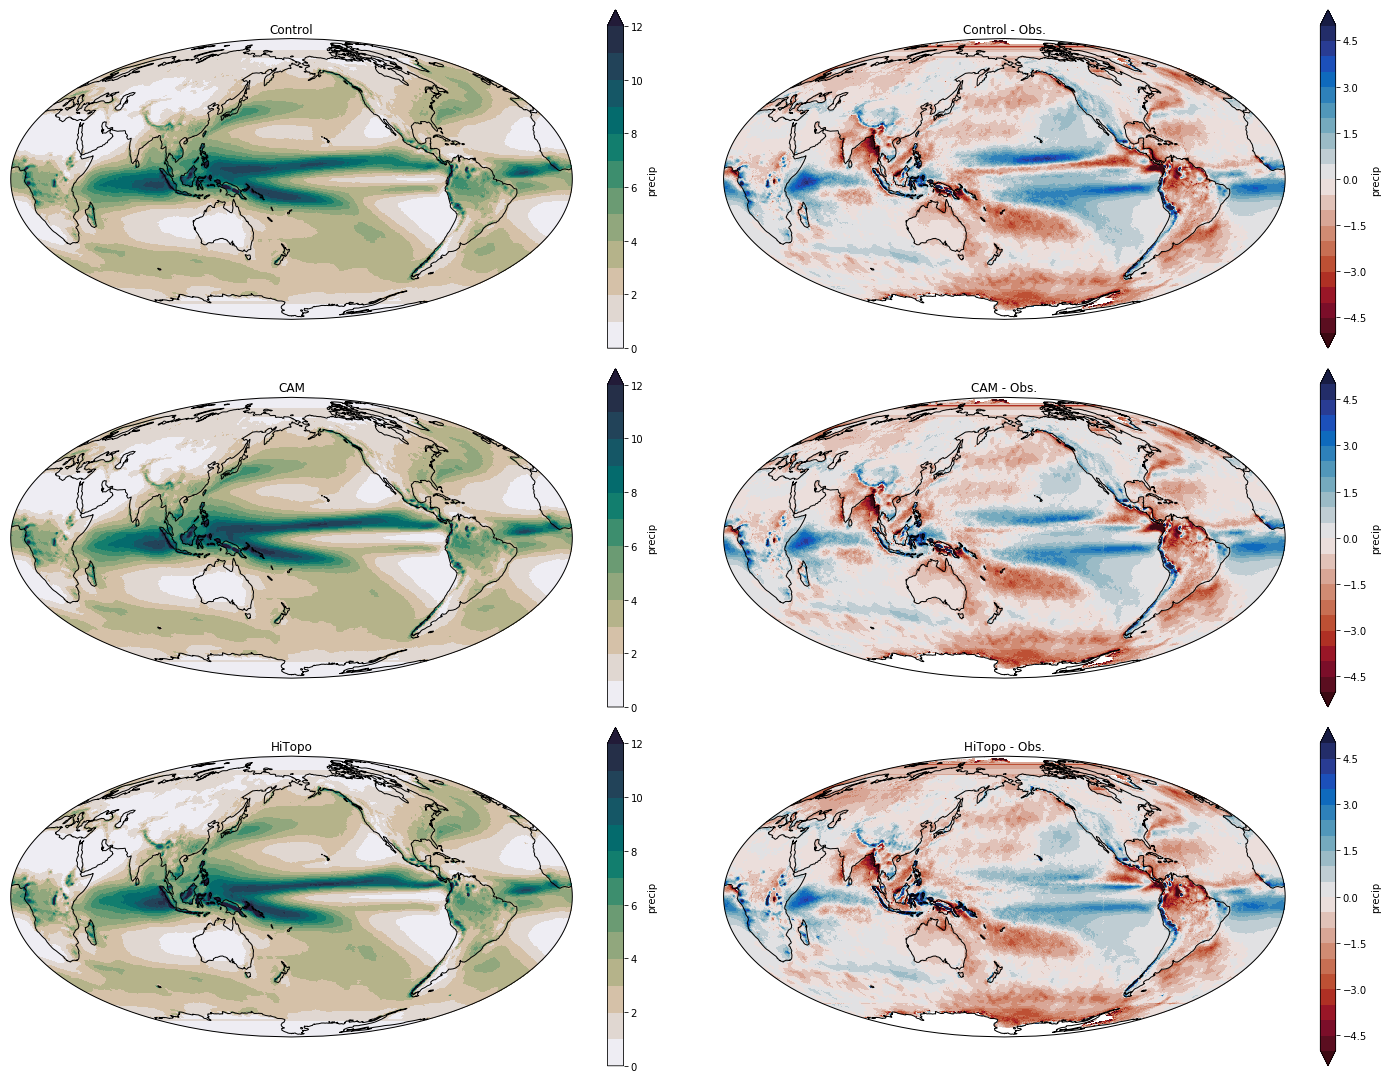

In [69]:
# Maps comparing model runs and observations

fig = plt.figure(figsize=(20,20))

lev = np.arange(0,13,1)
lev2 = np.arange(-5,5.5,0.5)
cmap = cmocean.cm.rain
cmap2 = cmocean.cm.balance_r
proj = ccrs.Mollweide(central_longitude=180)

ax1 = plt.subplot(4,2,1,projection=proj)
tmean['ctrl'].plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title('Control')

ax2 = plt.subplot(4,2,2,projection=proj)
diff['imerg']['ctrl'].plot(ax=ax2, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title('Control - Obs.')

ax3 = plt.subplot(4,2,3,projection=proj)
tmean['cam'].plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('CAM')

ax4 = plt.subplot(4,2,4,projection=proj)
diff['imerg']['cam'].plot(ax=ax4, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.set_title('CAM - Obs.')

ax5 = plt.subplot(4,2,5,projection=proj)
tmean['hitopo'].plot(ax=ax5, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax5.coastlines()
ax5.set_title('HiTopo')

ax6 = plt.subplot(4,2,6,projection=proj)
diff['imerg']['hitopo'].plot(ax=ax6, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree())
ax6.coastlines()
ax6.set_title('HiTopo - Obs.')

plt.tight_layout()

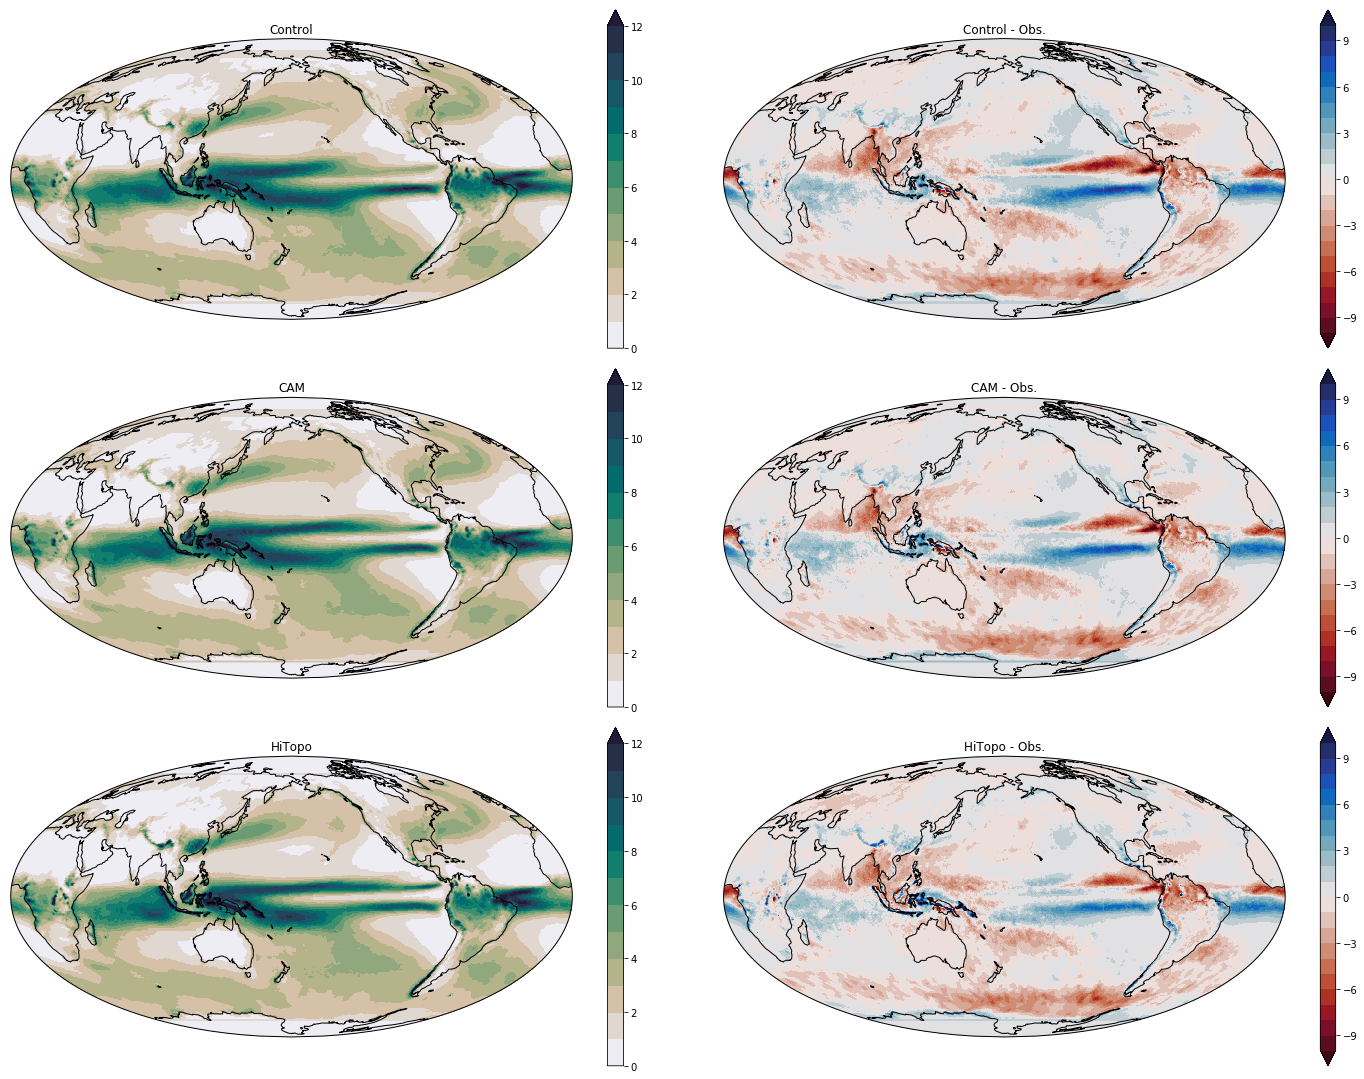

In [74]:
# Maps comparing model runs and observations MAM

fig = plt.figure(figsize=(20,20))

lev = np.arange(0,13,1)
lev2 = np.arange(-10,11,1)
cmap = cmocean.cm.rain
cmap2 = cmocean.cm.balance_r
proj = ccrs.Mollweide(central_longitude=180)

ax1 = plt.subplot(4,2,1,projection=proj)
seasmean['ctrl'].sel(season='MAM').plot(ax=ax1, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_title('Control')

ax2 = plt.subplot(4,2,2,projection=proj)
seas_diff['imerg']['ctrl'].sel(season='MAM').plot(ax=ax2, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title('Control - Obs.')

ax3 = plt.subplot(4,2,3,projection=proj)
seasmean['cam'].sel(season='MAM').plot(ax=ax3, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_title('CAM')

ax4 = plt.subplot(4,2,4,projection=proj)
seas_diff['imerg']['cam'].sel(season='MAM').plot(ax=ax4, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.set_title('CAM - Obs.')

ax5 = plt.subplot(4,2,5,projection=proj)
seasmean['hitopo'].sel(season='MAM').plot(ax=ax5, levels = lev, cmap = cmap, transform=ccrs.PlateCarree())
ax5.coastlines()
ax5.set_title('HiTopo')

ax6 = plt.subplot(4,2,6,projection=proj)
seas_diff['imerg']['hitopo'].sel(season='MAM').plot(ax=ax6, levels = lev2, cmap = cmap2, transform=ccrs.PlateCarree())
ax6.coastlines()
ax6.set_title('HiTopo - Obs.')

plt.tight_layout()